In [1]:
# This notebook is for creating random monotonic models of Uranus.
# The only constraints on the model are the that innermost shell has a temperature less than 50K
# and that the temperature/density/composition/pressure are monotonically decreasing as the radius increases.

In [2]:
import random
import numpy           as np
from matplotlib        import pyplot as plt
from matplotlib.pyplot import figure, legend

import lib.constants   as constants
import lib.profile     as profile
import lib.temperature as temperature

In [3]:
# Set for Uranus
mass = constants.URANUS.mass
moment_ratio = constants.URANUS.moment_ratio
radius = constants.URANUS.radius
num_shells = 100
max_temp = 50000
catalog = temperature.sio2_water_env_catalog()

In [4]:
# Create a bunch of random models.
# Note:  Running this cell will take a while (each model takes ~3 seconds),
# So generating 1000 should take about an hour.

good_models = []
for i in range(1000):
    seed, vals, count = profile.get_fixed_temp_model(mass, moment_ratio, radius, num_shells,
                                                     max_temp, catalog)
    if vals is not None:
        good_models.append((seed, vals, count))
        

In [5]:
# This cell is a list of the "valid models".
# The values you get are:
#
# idx, (seed, (r, w, e), count)
#
# Where:
# idx     -- The number of the model
# seed    -- The seed of model.   Save this to recreate a model below.
# (r,w,e) -- The rock/water/env ratio of the model.   Note that
#            these values only have meaning when we use a three-element
#            composition.
# count   -- The number of points during the model generation that were
#            set to Null.   We later "plaster ower" these points, but they
#            can potentially be points where the model is not monotonic
#            in one of its measures.

[x for x in enumerate(good_models)]

[(0, (0.253369217, (0.18, 0.77, 0.06), 0)),
 (1, (0.107703318, (0.23, 0.66, 0.11), 0)),
 (2, (0.419929481, (0.13, 0.77, 0.1), 0)),
 (3, (0.54062221, (0.23, 0.67, 0.1), 6)),
 (4, (0.437641282, (0.25, 0.6, 0.15), 6)),
 (5, (0.280786202, (0.19, 0.66, 0.14), 6)),
 (6, (0.315453465, (0.14, 0.75, 0.11), 2)),
 (7, (0.013061274, (0.3, 0.52, 0.17), 7)),
 (8, (0.468412764, (0.18, 0.79, 0.04), 0)),
 (9, (0.535532047, (0.3, 0.57, 0.12), 1)),
 (10, (0.177873198, (0.19, 0.65, 0.16), 1)),
 (11, (0.017100103, (0.42, 0.35, 0.23), 10)),
 (12, (0.840512827, (0.23, 0.65, 0.12), 3)),
 (13, (0.916832814, (0.09, 0.83, 0.08), 8)),
 (14, (0.428656414, (0.32, 0.54, 0.15), 1)),
 (15, (0.472554006, (0.41, 0.44, 0.15), 6)),
 (16, (0.059780044, (0.2, 0.65, 0.16), 8)),
 (17, (0.727442171, (0.23, 0.6, 0.16), 0)),
 (18, (0.950231183, (0.24, 0.67, 0.08), 0)),
 (19, (0.051815553, (0.22, 0.74, 0.04), 0)),
 (20, (0.440203133, (0.27, 0.58, 0.15), 0)),
 (21, (0.462267727, (0.3, 0.58, 0.12), 0)),
 (22, (0.608662664, (0.2, 0.

In [8]:
# You can go into more depth on specific models by reusing the seed of the model.
# As long as the max_temp/catalog/etc. is the same, this should recreate the model.

def full_model(seed):
    s, m, c = profile.get_fixed_temp_model(mass, moment_ratio, radius, num_shells, 
                                           max_temp, catalog,
                                           seed=seed, full_model=True)

    # Plot density
    m.plot_densities()
    legend()
    figure()
    
    # Plot pressure
    m.plot_pressure()
    legend()
    figure()
    
    # Plot temperature
    m.plot_temp(catalog)
    legend()
    figure()
    
    # Plot composition
    m.plot_rock()
    m.plot_env()
    legend()
    figure()

    # plot temp profiles
    m_profile = profile.TemperatureProfile(catalog, m)
    m_profile.plot_temperature_profiles()
    legend()
    figure()
    print(m.compute_ratios())


(0.32, 0.57, 0.11)


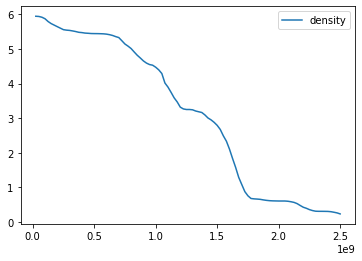

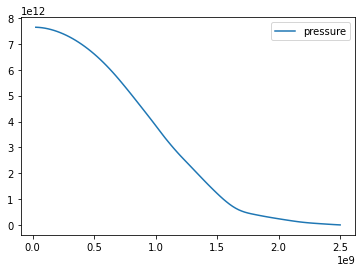

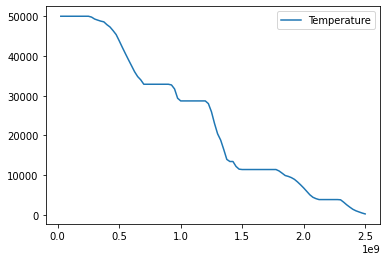

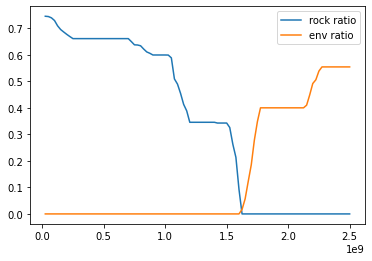

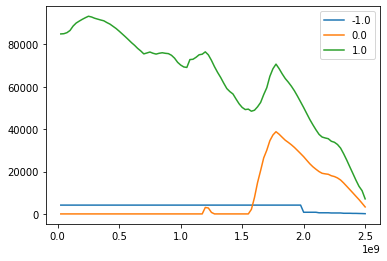

<Figure size 432x288 with 0 Axes>

In [9]:
# Enter the seed here, and it will generate all the major plots.

full_model(0.432223249)
#full_model(0.237874166)